In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
dataset = pd.read_csv('PJME_hourly.csv')
df = dataset.set_index('Datetime')
df.index = pd.to_datetime(df.index)
#df = df.resample('D').mean()
df = df.loc['20080101':'20160101']

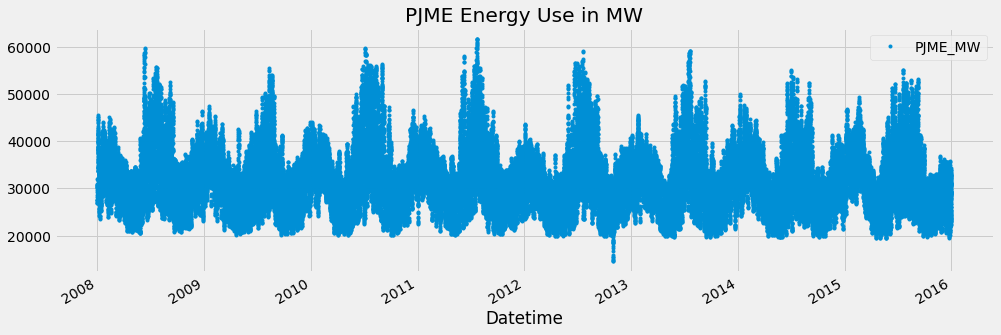

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

1. Outlier Analysis and removal

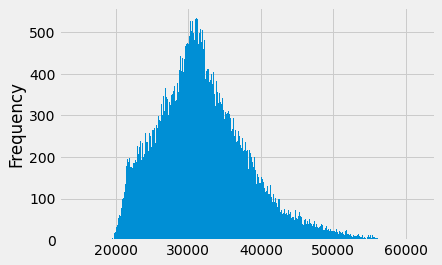

In [ ]:
df['PJME_MW'].plot(kind='hist', bins=500)

In [ ]:

df = df.query('PJME_MW > 19_000').copy()
df = df.query('PJME_MW < 60_000').copy()



In [ ]:
df.index


DatetimeIndex(['2008-01-01 00:00:00', '2008-12-31 01:00:00',
               '2008-12-31 02:00:00', '2008-12-31 03:00:00',
               '2008-12-31 04:00:00', '2008-12-31 05:00:00',
               '2008-12-31 06:00:00', '2008-12-31 07:00:00',
               '2008-12-31 08:00:00', '2008-12-31 09:00:00',
               ...
               '2016-01-01 14:00:00', '2016-01-01 15:00:00',
               '2016-01-01 16:00:00', '2016-01-01 17:00:00',
               '2016-01-01 18:00:00', '2016-01-01 19:00:00',
               '2016-01-01 20:00:00', '2016-01-01 21:00:00',
               '2016-01-01 22:00:00', '2016-01-01 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=70115, freq=None)

Reviewing: Train / Test Split

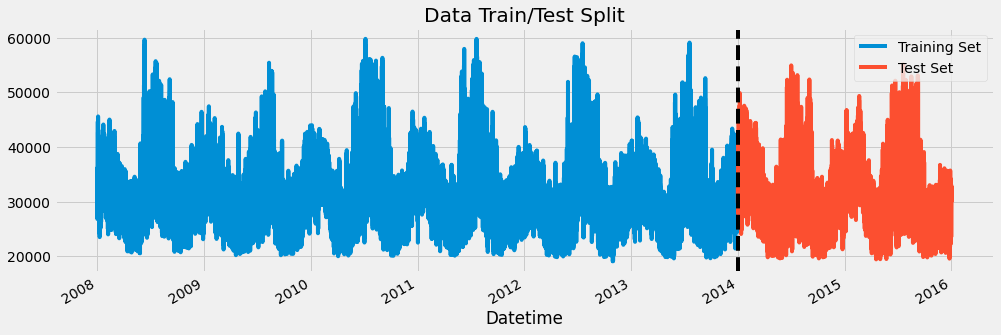

In [ ]:
#train = df.loc["df.index >= '01-01-2010' and df.index < '01-01-2017'"]
train = df.loc['20080101':'20140101']
test = df.loc[df.index >= '01-01-2014']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2014', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

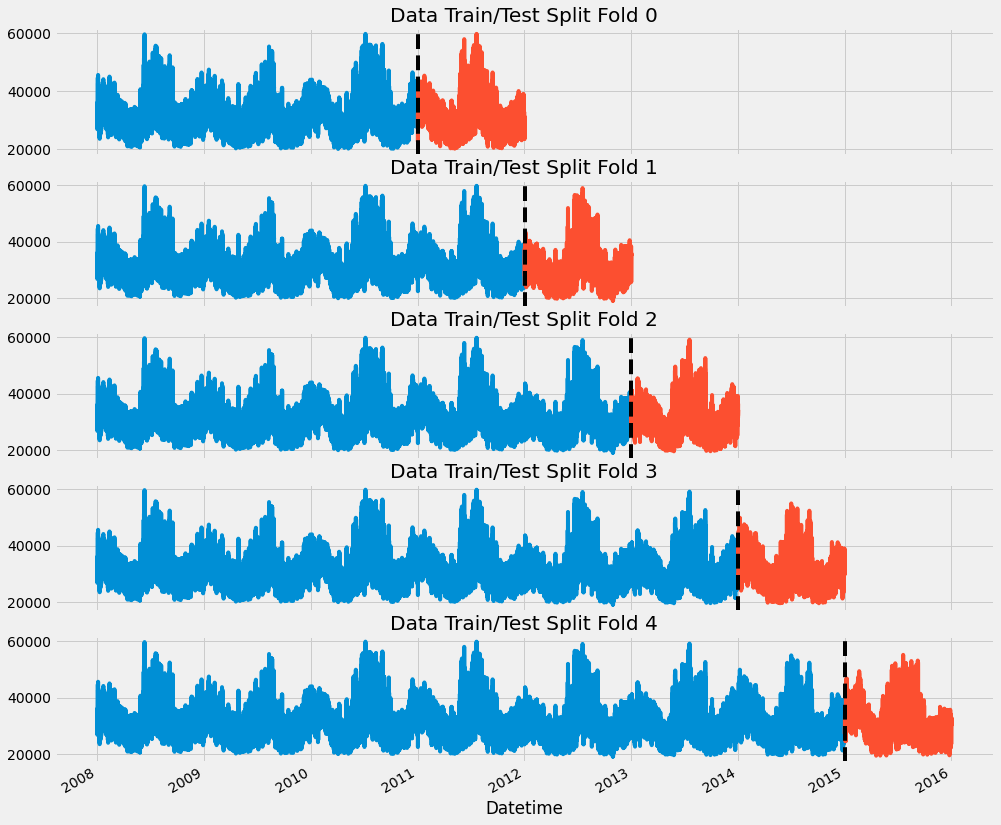

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
print(df)

                     PJME_MW  hour  dayofweek  quarter  month  year  \
Datetime                                                              
2008-01-01 00:00:00  30998.0     0          1        1      1  2008   
2008-01-01 01:00:00  29596.0     1          1        1      1  2008   
2008-01-01 02:00:00  28578.0     2          1        1      1  2008   
2008-01-01 03:00:00  27570.0     3          1        1      1  2008   
2008-01-01 04:00:00  26976.0     4          1        1      1  2008   
...                      ...   ...        ...      ...    ...   ...   
2016-01-01 19:00:00  32868.0    19          4        1      1  2016   
2016-01-01 20:00:00  32530.0    20          4        1      1  2016   
2016-01-01 21:00:00  32131.0    21          4        1      1  2016   
2016-01-01 22:00:00  31318.0    22          4        1      1  2016   
2016-01-01 23:00:00  29930.0    23          4        1      1  2016   

                     dayofyear  dayofmonth  weekofyear  
Datetime           

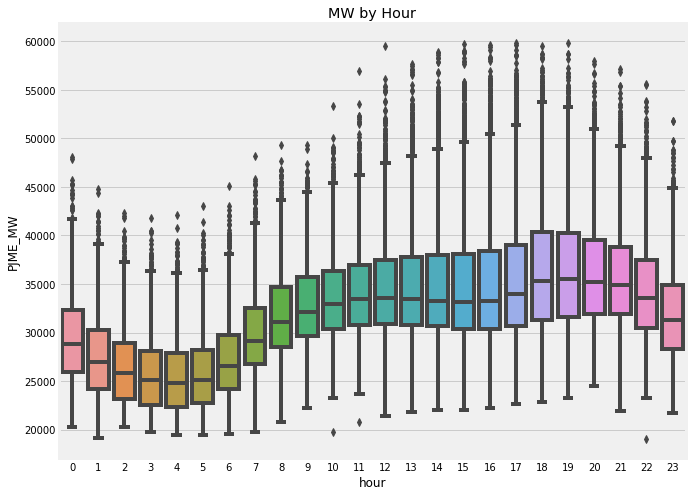

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

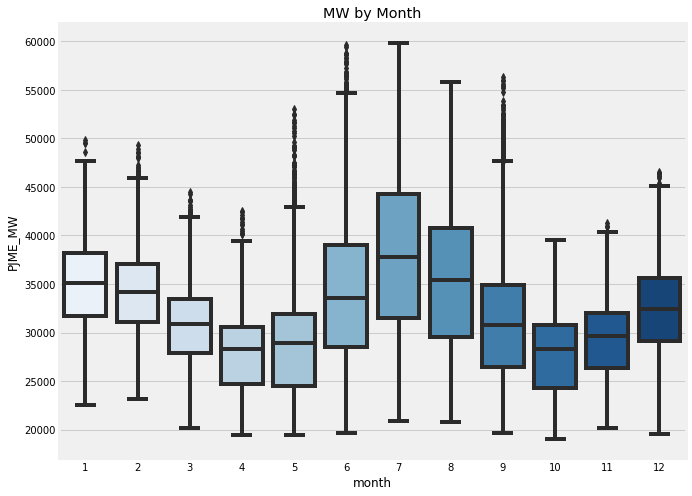

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

## **Train Using Cross Validation**
without Hyperparameter



In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

r2 = []
fold = 0
preds = []
scores = []
Mas_array = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective= 'reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    mas = mean_absolute_error(y_test, y_pred)
    Mas_array.append(mas)
    from sklearn.metrics import r2_score
    ss = r2_score(y_pred, y_test)
    r2.append(ss)
    print(ss)
    print(mas)

[0]	validation_0-rmse:32924	validation_1-rmse:32652.2
[100]	validation_0-rmse:12648.2	validation_1-rmse:12153.2
[200]	validation_0-rmse:5727.53	validation_1-rmse:5225.15
[300]	validation_0-rmse:3727.94	validation_1-rmse:3546.2
[400]	validation_0-rmse:3234.26	validation_1-rmse:3327.2
[500]	validation_0-rmse:3072.17	validation_1-rmse:3306.4
[600]	validation_0-rmse:2991.45	validation_1-rmse:3309.36
[700]	validation_0-rmse:2928.36	validation_1-rmse:3316.02
[800]	validation_0-rmse:2877.73	validation_1-rmse:3316.1
[900]	validation_0-rmse:2829.87	validation_1-rmse:3322.58
[999]	validation_0-rmse:2791.91	validation_1-rmse:3332.3
0.6950136059779529
2433.03689288135
[0]	validation_0-rmse:32858.2	validation_1-rmse:31812.1
[100]	validation_0-rmse:12618.9	validation_1-rmse:11293.3
[200]	validation_0-rmse:5719.1	validation_1-rmse:4445.96
[300]	validation_0-rmse:3740.99	validation_1-rmse:3134.37
[400]	validation_0-rmse:3252	validation_1-rmse:3163.49
[500]	validation_0-rmse:3100.31	validation_1-rmse:3

In [ ]:
print(np.mean(Mas_array)/np.mean(y_test)*100)

8.1331334610182


In [ ]:
print(f'Score across folds RMSE mean =  {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'Score across folds R2 mean =  {np.mean(r2):0.4f}')
print(f'Fold scores:{r2}')
print(f'Score across folds MAS mean =  {np.mean(Mas_array):0.4f}')
print(f'Fold scores:{Mas_array}')

Score across folds RMSE mean =  3472.2092
Fold scores:[3332.3044234323456, 3303.191352878275, 3649.600493212796, 3421.205076915163, 3654.744513008931]
Score across folds R2 mean =  0.6361
Fold scores:[0.6950136059779529, 0.7160647096018278, 0.6287192936974388, 0.6100243995818566, 0.5307358565403301]
Score across folds MAS mean =  2578.1167
Fold scores:[2433.03689288135, 2501.580703526327, 2708.6151862157535, 2520.4226152254564, 2726.9280206549656]


In [ ]:
#_ = plot_importance(reg, height=0.9)

#reg.plot_importance()

In [ ]:
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           #scoring = 'r2', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 100)

    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)
    return gsearch.best_params_

In [ ]:
#hyperParameterTuning(X_train, y_train)

## **Train Using Cross Validation**
with Hyperparameter Tuning



In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
r2 = []
Mas_array = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    #reg = xgb.XGBRegressor(objective='reg:squarederror')


    reg = xgb.XGBRegressor(colsample_bytree= 0.5,
 learning_rate= 0.01,
 max_depth= 7,
 min_child_weight = 5,
 n_estimators= 500,
 objective= 'reg:squarederror',
 subsample= 0.5   )
    """
    {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}
 """
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    mas = mean_absolute_error(y_test, y_pred)
    Mas_array.append(mas)
    from sklearn.metrics import r2_score
    ss = r2_score(y_pred, y_test)
    r2.append(ss)
    print(ss)
    print(mas)

[0]	validation_0-rmse:32924.4	validation_1-rmse:32649.5
[100]	validation_0-rmse:12587.4	validation_1-rmse:12240.8
[200]	validation_0-rmse:5377.36	validation_1-rmse:5202.61
[300]	validation_0-rmse:3019.82	validation_1-rmse:3357.8
[400]	validation_0-rmse:2309.87	validation_1-rmse:3097.23
[499]	validation_0-rmse:2059.36	validation_1-rmse:3106.95
0.7156274760902063
2284.7465568368293
[0]	validation_0-rmse:32858.8	validation_1-rmse:31816.9
[100]	validation_0-rmse:12558.7	validation_1-rmse:11612.5
[200]	validation_0-rmse:5388.85	validation_1-rmse:4850.74
[300]	validation_0-rmse:3069.07	validation_1-rmse:3296.93
[400]	validation_0-rmse:2404.44	validation_1-rmse:3166.48
[499]	validation_0-rmse:2149	validation_1-rmse:3224.54
0.6647660380680817
2393.9134741099456
[0]	validation_0-rmse:32653.1	validation_1-rmse:32013.4
[100]	validation_0-rmse:12493.3	validation_1-rmse:12305.3
[200]	validation_0-rmse:5378.53	validation_1-rmse:5672.47
[300]	validation_0-rmse:3123.12	validation_1-rmse:3917.93
[400]	

In [ ]:
print(f'Score across folds RMSE mean with hyperparameter tuning =  {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'Score across folds R2 mean with hyperparameter tuning =  {np.mean(r2):0.4f}')
print(f'Fold scores:{r2}')
print(f'Score across folds MAS mean =  {np.mean(Mas_array):0.4f}')
print(f'Fold scores:{Mas_array}')


Score across folds RMSE mean with hyperparameter tuning =  3321.0108
Fold scores:[3106.9519352993707, 3224.5406659888513, 3516.8527468446196, 3231.792911008237, 3524.9159305370817]
Score across folds R2 mean with hyperparameter tuning =  0.6231
Fold scores:[0.7156274760902063, 0.6647660380680817, 0.5893592700326702, 0.6197555918582875, 0.5261675670674661]
Score across folds MAS mean =  2459.8103
Fold scores:[2284.7465568368293, 2393.9134741099456, 2659.0448235498716, 2353.1842664187357, 2608.1621301102314]


In [ ]:
print(np.mean(Mas_array)/np.mean(y_test)*100)

7.75991450665498


# **Using LSTM**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
%matplotlib inline

In [ ]:
"""tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
r2 = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]


    Training_Set = test.values
    sc = MinMaxScaler(feature_range=(0, 1))
    Train = sc.fit_transform(Training_Set)










    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    from sklearn.metrics import r2_score
    ss = r2_score(y_pred, y_test)
    r2.append(ss)
    print(ss)"""

"tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)\ndf = df.sort_index()\n\n\nfold = 0\npreds = []\nscores = []\nr2 = []\nfor train_idx, val_idx in tss.split(df):\n    train = df.iloc[train_idx]\n    test = df.iloc[val_idx]\n\n    train = create_features(train)\n    test = create_features(test)\n\n    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']\n    TARGET = 'PJME_MW'\n\n    X_train = train[FEATURES]\n    y_train = train[TARGET]\n\n    X_test = test[FEATURES]\n    y_test = test[TARGET]\n\n\n    Training_Set = test.values\n    sc = MinMaxScaler(feature_range=(0, 1))\n    Train = sc.fit_transform(Training_Set)\n\n\n    \n\n\n\n\n\n\n\n    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    \n                           n_estimators=1000,\n                           early_stopping_rounds=50,\n                           objective='reg:squarederror',\n                           max_depth=3,\n                           learning_rate=0.01)\n    